## Imports

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
import math

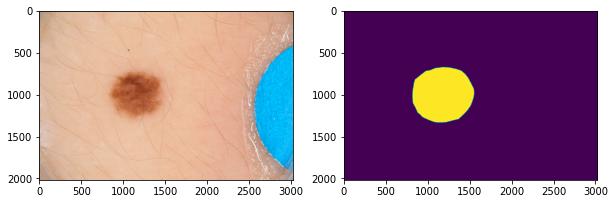

In [12]:
#Ex1
image1,image1_seg = findImage('ISIC_0007156')

f, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(image1)
axes[1].imshow(image1_seg)

In [13]:
#Ex2
#Dimensions are the same, but the first image has rgb, whereas the second just 0 and 1 
print(image1.shape)
print(image1_seg.shape)

(2016, 3024, 3)
(2016, 3024)


In [14]:
#Ex3 - max width, max height, max diameter
#plt.imshow(image1_seg)

circle = np.where(image1_seg==1)

pixels = []
for i in range(len(circle[0])):
    pixels.append((circle[0][i],circle[1][i]))

pixels #coordinates of the lesion

#Max width, max height
print("Max height", max(circle[0]) - min(circle[0]))
print("Max width", max(circle[1])-min(circle[1]))

Max height 657
Max width 735


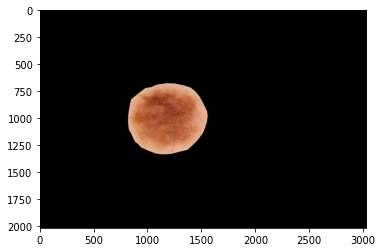

In [15]:
#Ex4 mask out around skin lesion

mask = image1_seg == 0
copy = image1.copy()
copy[mask] = [0,0,0]
plt.imshow(copy)

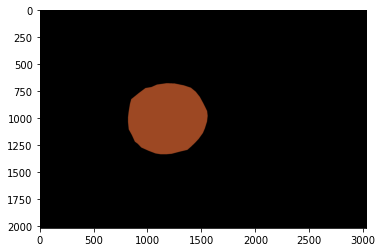

In [16]:
#Ex5 color, and fill the whole place with the colour
list(copy[1000,1200])
mask2 = image1_seg == 1

copy[mask2] = list(copy[1000,1200])

plt.imshow(copy)

## Functions

In [117]:
def average_colour(image,segmentation):
    mask = segmentation == 1
    copy = image.copy()
    r = np.mean(copy[mask,0])
    g = np.mean(copy[mask,1])
    b = np.mean(copy[mask,2])
    #num_of_pixels = copy[mask].shape[0]
    return [r,g,b]

def deviation_of_colour(image,segmentation):
    mask = segmentation == 1
    copy = image.copy()
    r = np.std(copy[mask,0])
    g = np.std(copy[mask,1])
    b = np.std(copy[mask,2])
    return [r,g,b]

def average_luminosity(image,segmentation):
    avg_colour = average_colour(image,segmentation)
    return 0.299*avg_colour[0] + 0.587*avg_colour[1] + 0.114*avg_colour[2]

def deviation_luminosity(image,segmentation):
    deviation_colour = deviation_of_colour(image,segmentation)
    return np.sqrt(0.299**2*deviation_colour[0]**2 + 0.587**2*deviation_colour[1]**2 + 0.114**2*deviation_colour[2]**2)

def findImage(image_id):
    image = plt.imread('../data/example_image/'+image_id+'.jpg')
    image_seg = plt.imread('../data/example_segmentation/'+image_id+'_segmentation.png')
    
    return image,image_seg

def calculate_area(segmentation):
    x = np.sum(segmentation)
    return x

def calculate_border(image,thickness):
    """
    image = np array of a picture
    thicness = an integer of the thiccness of the border
    returns = the border of the figure
    """
    struct_el = morphology.disk(thickness)
    mask_eroded = morphology.binary_erosion(image, struct_el)
    return calculate_area(image)-np.sum(mask_eroded)


def compactness(area, border):
    """
    area = the area of the figure
    border = the circumference of the figure
    return = returns the compactness
    """
    top = border**2
    bot = 4*math.pi*area
    return top/bot

## Read data

In [18]:
    #all data
file_input = pd.read_csv("../data/example_ground_truth.csv")
# data frame for images with no diagnosis
non_malignant_df = file_input.loc[(file_input['melanoma'] == 0.0) & (file_input["seborrheic_keratosis"] == 0.0)]
malignant_df = file_input.loc[(file_input['melanoma'] == 1.0) & (file_input["seborrheic_keratosis"] == 1.0)]

#Melanoma
melanoma = file_input[file_input["melanoma"] == 1.0]
melanoma_df = melanoma.drop(["seborrheic_keratosis"], axis = 1)

#read file features
file_features_df = pd.read_csv("../features/features.csv")
#rename column 'id' to 'image_id'
file_features_df.rename(columns={'id': 'image_id'}, inplace=True)

#merge data frame for file_features_df with melanoma by column 'image_id'
merge_feature_melanoma = file_features_df.merge(melanoma_df, on='image_id', how='right')

#merge all data
all_feature_merge = file_features_df.merge(file_input, on='image_id', how='right')

#all malignant with features
feature_malignant = file_features_df.merge(malignant_df, on='image_id', how='right')

#all not malignant with features
feature_non_malignant = file_features_df.merge(non_malignant_df, on='image_id', how='right')


#-------------DATAFRAMES---------------
file_input #All the ground data
non_malignant_df #ALl healthy ground data
malignant_df #All cancerous ground data
melanoma_df #Melanoma ground dat
file_features_df #Features
merge_feature_melanoma # Melanoma with features
all_feature_merge # All the data we have (ground + feature)
feature_malignant #Malignant data with features
feature_non_malignant #Healthy features

,image_id,area,perimeter,melanoma,seborrheic_keratosis
0,ISIC_0001769,216160.0,2013.0,0.0,0.0
1,ISIC_0001852,130493.0,1372.0,0.0,0.0
2,ISIC_0001871,205116.0,1720.0,0.0,0.0
3,ISIC_0003462,161705.0,1344.0,0.0,0.0
4,ISIC_0003539,317040.0,2063.0,0.0,0.0
...,...,...,...,...,...
73,ISIC_0015443,9732988.0,13775.0,0.0,0.0
74,ISIC_0015445,12049938.0,19517.0,0.0,0.0
75,ISIC_0015483,8856478.0,13813.0,0.0,0.0
76,ISIC_0015496,8951522.0,13742.0,0.0,0.0


In [124]:
#Export features from images

df = pd.DataFrame()
data = pd.DataFrame()
count = 0
rows = []
for image_id in all_feature_merge['image_id']:
    print(image_id,count)
    
    image = plt.imread('../data/example_image/'+image_id+'.jpg')
    image_seg = plt.imread('../data/example_segmentation/'+image_id+'_segmentation.png')
    #data['image_id'] = image_id
    real_area = int(all_feature_merge[all_feature_merge['image_id'] == image_id]['area'])
    real_perimeter = int(all_feature_merge[all_feature_merge['image_id'] == image_id]['perimeter'])
    melanoma = int(all_feature_merge[all_feature_merge['image_id'] == image_id]['melanoma'])
    seborrheic_keratosis = int(all_feature_merge[all_feature_merge['image_id'] == image_id]['seborrheic_keratosis'])
    calculated_area = int(calculate_area(image_seg))
    calculated_perimeter = calculate_border(image_seg,2)
    imgCompactness = compactness(calculate_area(image_seg),calculate_border(image_seg,1))
    average_rgb = average_colour(image,image_seg)
    deviation_of_rgb = deviation_of_colour(image,image_seg)
    average_luminosity_img = average_luminosity(image,image_seg)
    deviation_luminosity_img = deviation_luminosity(image,image_seg)
    row = [image_id, real_area, real_perimeter,melanoma,seborrheic_keratosis,calculated_area,calculated_perimeter,imgCompactness,average_rgb,deviation_of_rgb,average_luminosity_img,deviation_luminosity_img]
    rows.append(row)
    count+= 1

data = pd.DataFrame(rows, columns = ['image_id','real_area','real_perimeter','melanoma','seborrheic_keratosis','calculated_area','calculated_perimeter','compactness','average_rgb','deviation_of_colour','average_luminosity','deviation_luminosity'])

ISIC_0001769 0
ISIC_0001852 1
ISIC_0001871 2
ISIC_0003462 3
ISIC_0003539 4
ISIC_0003582 5
ISIC_0003657 6
ISIC_0003805 7
ISIC_0004337 8
ISIC_0006651 9
ISIC_0006671 10
ISIC_0006815 11
ISIC_0006914 12
ISIC_0007141 13
ISIC_0007156 14
ISIC_0007235 15
ISIC_0007241 16
ISIC_0007332 17
ISIC_0007344 18
ISIC_0007528 19
ISIC_0007796 20
ISIC_0008025 21
ISIC_0008524 22
ISIC_0009995 23
ISIC_0010459 24
ISIC_0012099 25
ISIC_0012109 26
ISIC_0012126 27
ISIC_0012127 28
ISIC_0012143 29
ISIC_0012151 30
ISIC_0012159 31
ISIC_0012160 32
ISIC_0012191 33
ISIC_0012201 34
ISIC_0012204 35
ISIC_0012206 36
ISIC_0012210 37
ISIC_0012221 38
ISIC_0012222 39
ISIC_0012254 40
ISIC_0012256 41
ISIC_0012288 42
ISIC_0012306 43
ISIC_0012313 44
ISIC_0012316 45
ISIC_0012335 46
ISIC_0012380 47
ISIC_0012383 48
ISIC_0012400 49
ISIC_0012417 50
ISIC_0012434 51
ISIC_0012492 52
ISIC_0012513 53
ISIC_0012538 54
ISIC_0012547 55
ISIC_0012660 56
ISIC_0012684 57
ISIC_0012720 58
ISIC_0012746 59
ISIC_0012876 60
ISIC_0012927 61
ISIC_0012956 62
IS

In [126]:
data

,image_id,real_area,real_perimeter,melanoma,seborrheic_keratosis,calculated_area,calculated_perimeter,compactness,average_rgb,deviation_of_colour,average_luminosity,deviation_luminosity
0,ISIC_0001769,216160,2013,0,0,216160,3982.0,1.491772,"[162.07149333826794, 99.30780440414507, 67.786...","[12.205123532436513, 18.754262929408846, 19.89...",114.480686,11.817479
1,ISIC_0001852,130493,1372,0,0,130493,2718.0,1.147919,"[116.74907466300874, 54.64894668679546, 33.087...","[31.27789052350099, 32.07510414646571, 25.0998...",70.758871,21.216643
2,ISIC_0001871,205116,1720,0,0,205116,3412.0,1.147751,"[182.21681390042707, 134.7412049766961, 102.53...","[6.3898744270946, 12.975379982675513, 19.33878...",145.265327,8.156129
3,ISIC_0003462,161705,1344,0,0,161705,2683.0,0.888925,"[165.82234315574658, 116.78643826721499, 87.55...","[13.467871330386464, 27.312125552850148, 34.95...",128.115611,17.003706
4,ISIC_0003539,317040,2063,0,0,317040,4120.0,1.068254,"[165.12712276053495, 99.63897930860459, 63.168...","[23.770632535623616, 33.005983134923085, 30.47...",115.062269,20.927490
...,...,...,...,...,...,...,...,...,...,...,...,...
145,ISIC_0015443,9732988,13775,0,0,9732988,27463.0,1.551412,"[139.39421737702747, 89.18466076399149, 63.660...","[14.693926319508012, 21.175403762962702, 27.40...",101.287584,13.548701
146,ISIC_0015445,12049938,19517,0,0,12049938,39025.0,2.515541,"[154.57732197460268, 91.72927727926898, 82.038...","[47.62813987684408, 41.48168846201185, 40.1837...",109.416063,28.577897
147,ISIC_0015483,8856478,13813,0,0,8856478,27534.0,1.714372,"[142.42447065300675, 105.85834335048311, 92.20...","[38.30387070156361, 34.627307043981304, 33.481...",115.234832,23.640907
148,ISIC_0015496,8951522,13742,0,0,8951522,27392.0,1.678778,"[172.3990948131502, 98.74436403105528, 77.7044...","[71.20114045798132, 56.41305374592664, 50.9847...",118.368574,39.794190


,image_id,area,perimeter,melanoma,seborrheic_keratosis
0,ISIC_0001769,216160.0,2013.0,0.0,0.0
1,ISIC_0001852,130493.0,1372.0,0.0,0.0
2,ISIC_0001871,205116.0,1720.0,0.0,0.0
3,ISIC_0003462,161705.0,1344.0,0.0,0.0
4,ISIC_0003539,317040.0,2063.0,0.0,0.0
...,...,...,...,...,...
145,ISIC_0015443,9732988.0,13775.0,0.0,0.0
146,ISIC_0015445,12049938.0,19517.0,0.0,0.0
147,ISIC_0015483,8856478.0,13813.0,0.0,0.0
148,ISIC_0015496,8951522.0,13742.0,0.0,0.0


In [118]:
img1,img2 = findImage('ISIC_0015483')

8856478

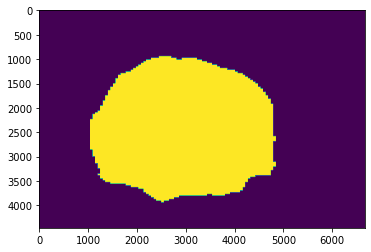

In [121]:
plt.imshow(img2)
int(calculate_area(img2))